In [1]:
# import of necessary files from other folders

import os
import sys
import ast

# libraries imports

import importlib
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import seaborn as sns
import pandas as pd
import pickle

from IPython.display import Image, display
from PIL import Image
from pathlib import Path
from scipy.integrate import solve_ivp
from matplotlib.colors import LinearSegmentedColormap,TwoSlopeNorm

# Set default figure and axes background color to white
plt.rcParams['figure.facecolor'] = 'white'  # Background for the entire figure
plt.rcParams['axes.facecolor'] = 'white' 

# Function to check if a string can be converted to a float or an integer
def is_number(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

## Importing dataframe

In [ ]:
df_complete = pd.read_pickle('path to dataframe')

In [27]:
from scipy.stats import entropy

sampled_data=df_complete.copy()
# Apply the function to compute Shannon diversity and add it as a new column
sampled_data['shannon_F'] = sampled_data['sh_sp_F'].apply(lambda x: x[-1])
sampled_data['productivity'] = sampled_data['g'].apply(lambda x: np.mean(x))

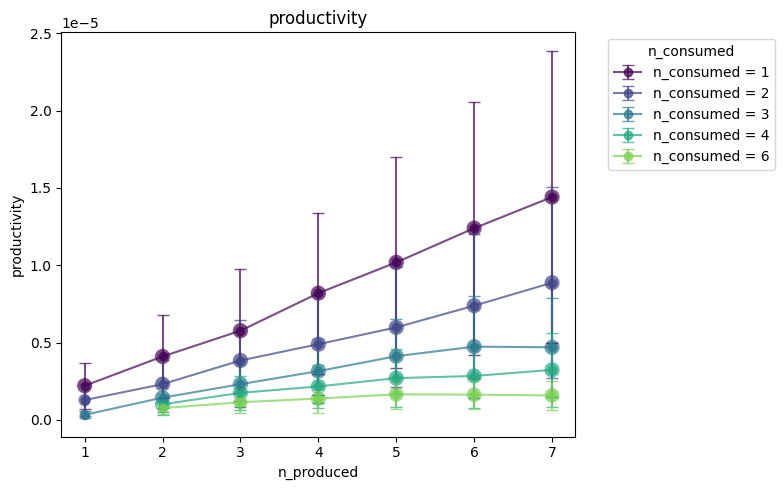

In [28]:
import matplotlib.colors as mcolors

# Assuming df_filtered is your DataFrame containing the data
unique_n_consumed = sampled_data['n_consumed'].unique()

# Sort the 'n_consumed' values so colors are assigned in increasing order
unique_n_consumed = np.sort(unique_n_consumed)

# Set up the figure with two subplots (one for Shannon F, one for Shannon O)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex=True, sharey=True)

# Define a discrete version of the 'viridis' colormap with enough distinct colors
n_colors = len(unique_n_consumed)
cmap = plt.cm.viridis  # Use 'viridis' colormap
colors = [cmap(i / n_colors) for i in range(n_colors)]  # Discretize the colormap

# Loop through each unique 'n_consumed' and plot data for Shannon F and Shannon O
for i, n_cons in enumerate(unique_n_consumed):
    # Filter data for the current 'n_consumed' value
    current_data = sampled_data[sampled_data['n_consumed'] == n_cons]
    
    # Group by 'n_produced' for the current data
    grouped_data = current_data.groupby('n_produced').agg(
        shannon_sp_avg=('productivity', 'mean'),
        shannon_sp_std=('productivity', 'std'),
        count=('productivity', 'size')
    ).reset_index()

    # Calculate marker sizes based on count
    marker_sizes = np.sqrt(grouped_data['count']) * 30  # Adjust multiplier for appropriate scaling
    
    # Plot Shannon F on the first subplot
    axes.errorbar(
        grouped_data['n_produced'], 
        grouped_data['shannon_sp_avg'], 
        yerr=grouped_data['shannon_sp_std'], 
        fmt='-o', color=colors[i], label=f'n_consumed = {n_cons}', alpha=0.7, capsize=4
    )
    axes.scatter(
        grouped_data['n_produced'], 
        grouped_data['shannon_sp_avg'], 
        s=marker_sizes, color=colors[i], alpha=0.7, edgecolor='w', linewidth=0.5
    )
    

# Add titles and labels
axes.set_title('productivity', fontsize=12)

axes.set_xlabel('n_produced', fontsize=10)
axes.set_ylabel('productivity', fontsize=10)
    
# Add a legend
axes.legend(title="n_consumed", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

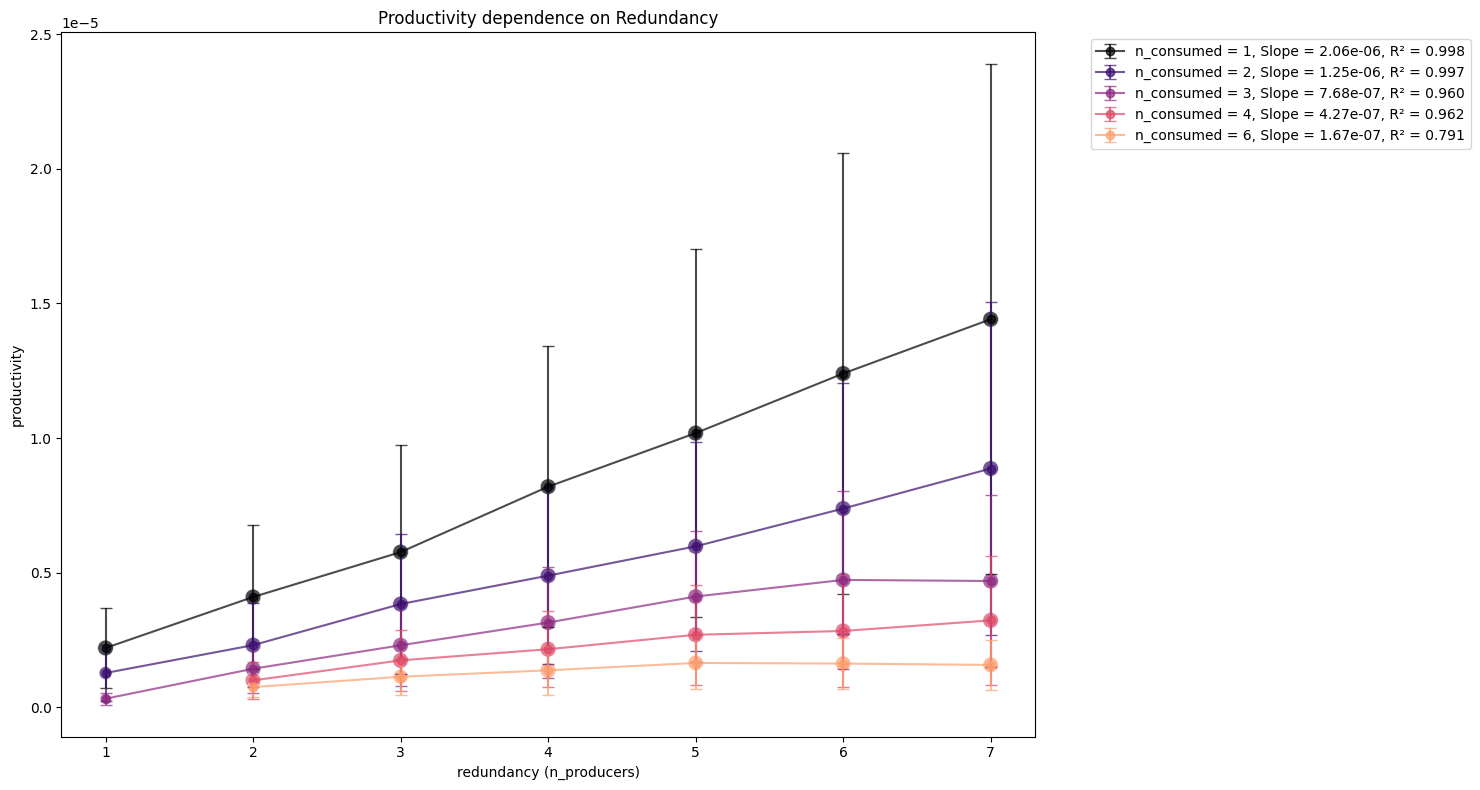

In [34]:
from scipy.stats import linregress

# Assuming df_filtered is your DataFrame containing the data
unique_n_consumed = sampled_data['n_consumed'].unique()

# Sort the 'n_consumed' values so colors are assigned in increasing order
unique_n_consumed = np.sort(unique_n_consumed)

# Set up the figure with one subplot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8), sharex=True, sharey=True)

# Define a discrete version of the 'magma' colormap with enough distinct colors
n_colors = len(unique_n_consumed)
cmap = plt.cm.magma  # Use 'magma' colormap
colors = [cmap(i / n_colors) for i in range(n_colors)]  # Discretize the colormap

# Dictionary to store slope and R squared values
correlation_info = {}

# Loop through each unique 'n_consumed' and plot data for Shannon F and Shannon O
for i, n_cons in enumerate(unique_n_consumed):
    # Filter data for the current 'n_consumed' value
    current_data = sampled_data[sampled_data['n_consumed'] == n_cons]
    
    # Group by 'n_produced' for the current data
    grouped_data = current_data.groupby('n_produced').agg(
        shannon_sp_avg=('productivity', 'mean'),
        shannon_sp_std=('productivity', 'std'),
        count=('productivity', 'size')
    ).reset_index()

    # Calculate marker sizes based on count
    marker_sizes = np.sqrt(grouped_data['count']) * 30  # Adjust multiplier for appropriate scaling
    
    # Perform linear regression and calculate R squared
    if len(grouped_data) > 1:  # Ensure there is more than one data point to calculate correlation
        slope, intercept, r_value, p_value, std_err = linregress(grouped_data['n_produced'], grouped_data['shannon_sp_avg'])
        r_squared = r_value ** 2
        correlation_info[n_cons] = (slope, r_squared)
    else:
        correlation_info[n_cons] = (None, None)
    
    # Plot Shannon F on the first subplot
    ax.errorbar(
        grouped_data['n_produced'], 
        grouped_data['shannon_sp_avg'], 
        yerr=grouped_data['shannon_sp_std'], 
        fmt='-o', color=colors[i], label=f'n_consumed = {n_cons}, Slope = {slope:.2e}, R² = {r_squared:.3f}', alpha=0.7, capsize=4
    )
    ax.scatter(
        grouped_data['n_produced'], 
        grouped_data['shannon_sp_avg'], 
        s=marker_sizes, color=colors[i], alpha=0.7, edgecolor='w', linewidth=0.5
    )

# Add titles and labels
ax.set_title('Productivity dependence on Redundancy', fontsize=12)
ax.set_xlabel('redundancy (n_producers)', fontsize=10)
ax.set_ylabel('productivity', fontsize=10)
    
# Add a legend
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

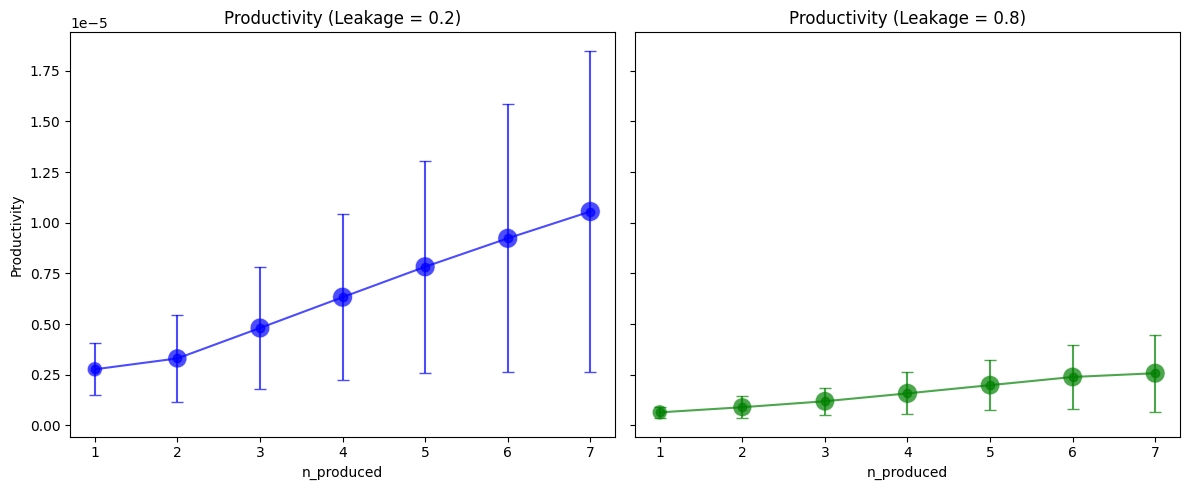

In [12]:
# Separate data for each leakage group
sampled_0_2 = sampled_data[sampled_data['l'] == 0.2]
sampled_0_8 = sampled_data[sampled_data['l'] == 0.8]

# Function to compute mean and std for each 'n_produced'
def compute_grouped_stats(data):
    return data.groupby('n_produced').agg(
        productivity_avg=('productivity', 'mean'),
        productivity_std=('productivity', 'std'),
        count=('productivity', 'size')
    ).reset_index()

# Compute stats for both leakage groups
grouped_0_2 = compute_grouped_stats(sampled_0_2)
grouped_0_8 = compute_grouped_stats(sampled_0_8)

# Calculate marker sizes
grouped_0_2['marker_size'] = np.sqrt(grouped_0_2['count']) * 30
grouped_0_8['marker_size'] = np.sqrt(grouped_0_8['count']) * 30

# Create the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Define a plotting function
def plot_productivity(ax, grouped_data, title, color):
    ax.errorbar(
        grouped_data['n_produced'], 
        grouped_data['productivity_avg'], 
        yerr=grouped_data['productivity_std'], 
        fmt='-o', color=color, alpha=0.7, capsize=4
    )
    ax.scatter(
        grouped_data['n_produced'], 
        grouped_data['productivity_avg'], 
        s=grouped_data['marker_size'], 
        color=color, alpha=0.7, edgecolor='w', linewidth=0.5
    )
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('n_produced', fontsize=10)

# Plot for leakage = 0.2
plot_productivity(axes[0], grouped_0_2, 'Productivity (Leakage = 0.2)', 'blue')
axes[0].set_ylabel('Productivity', fontsize=10)

# Plot for leakage = 0.8
plot_productivity(axes[1], grouped_0_8, 'Productivity (Leakage = 0.8)', 'green')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

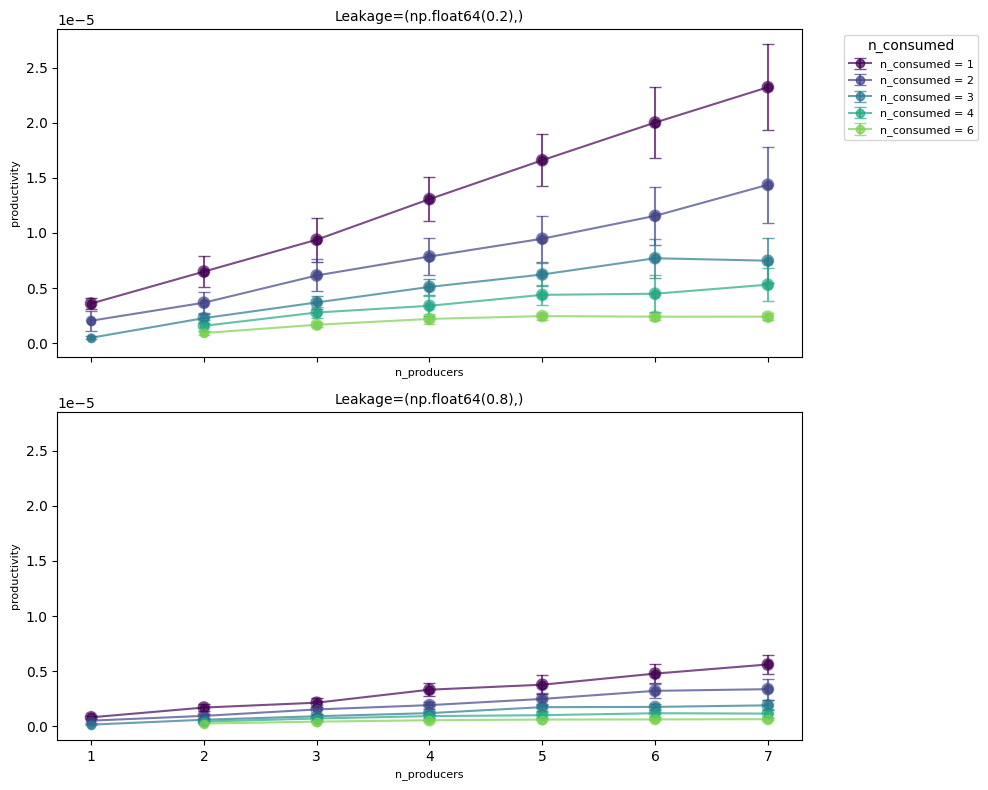

In [7]:
import itertools

# Generate parameter combinations
leakage_values = sampled_data['l'].unique()
combinations = list(itertools.product(leakage_values))

# Set up the figure with 27 subplots (each with 2 panels)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes for easier iteration

# Define a discrete version of the 'viridis' colormap with enough distinct colors
n_colors = len(unique_n_consumed)
cmap = plt.cm.viridis  # Use 'viridis' colormap
colors = [cmap(i / n_colors) for i in range(n_colors)]  # Discretize the colormap

# Loop through each parameter combination and create plots
for idx, (leakage) in enumerate(combinations):
    # Filter data for the current combination
    combo_data = sampled_data[
        (sampled_data['l'] == leakage) 
    ]
    
    # Prepare axes for Shannon F and Shannon O
    ax_F = axes[idx]      # First panel for Shannon F
    
    # Loop through each unique 'n_consumed' and plot data for Shannon F and O
    for i, n_cons in enumerate(unique_n_consumed):
        current_data = combo_data[combo_data['n_consumed'] == n_cons]
        grouped_data = current_data.groupby('n_produced').agg(
            shannon_sp_avg=('productivity', 'mean'),
            shannon_sp_std=('productivity', 'std'),
            count=('productivity', 'size')
        ).reset_index()
        
        # Calculate marker sizes
        marker_sizes = np.sqrt(grouped_data['count']) * 30
        
        # Plot Shannon F
        ax_F.errorbar(
            grouped_data['n_produced'], 
            grouped_data['shannon_sp_avg'], 
            yerr=grouped_data['shannon_sp_std'], 
            fmt='-o', color=colors[i], label=f'n_consumed = {n_cons}', alpha=0.7, capsize=4
        )
        ax_F.scatter(
            grouped_data['n_produced'], 
            grouped_data['shannon_sp_avg'], 
            s=marker_sizes, color=colors[i], alpha=0.7, edgecolor='w', linewidth=0.5
        )
        

    # Set titles for the current parameter combination
    ax_F.set_title(f'Leakage={leakage}', fontsize=10)    
    # Set axis labels
    ax_F.set_xlabel('n_producers', fontsize=8)
    ax_F.set_ylabel('productivity', fontsize=8)

# Add a legend to the first panel
axes[0].legend(title="n_consumed", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Adjust layout and display
plt.tight_layout()
plt.show()

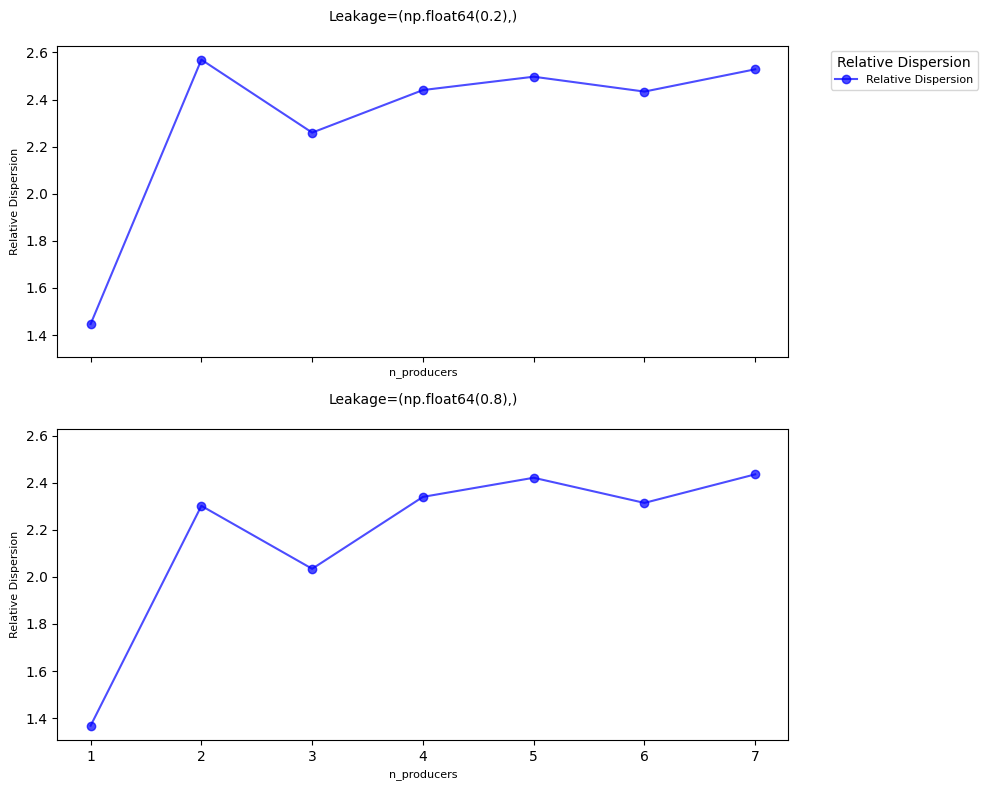

In [8]:
unique_n_consumed = sampled_data['n_consumed'].unique()

# Generate parameter combinations
leakage_values = sampled_data['l'].unique()
combinations = list(itertools.product(leakage_values))

# Set up the figure with 27 subplots (each with 2 panels)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes for easier iteration

# Define a discrete version of the 'viridis' colormap with enough distinct colors
n_colors = len(unique_n_consumed)
cmap = plt.cm.viridis  # Use 'viridis' colormap
colors = [cmap(i / n_colors) for i in range(n_colors)]  # Discretize the colormap

# Loop through each parameter combination and create plots
for idx, (leakage) in enumerate(combinations):
    # Filter data for the current combination
    combo_data = sampled_data[(sampled_data['l'] == leakage)]
    
    # Prepare axes for relative dispersion
    ax_dispersion = axes[idx]  # Panel for relative dispersion

    # Initialize a DataFrame to store filtered data
    filtered_data = pd.DataFrame()

    # Loop through each unique 'n_consumed' to remove outliers
    for n_cons in unique_n_consumed:
        current_data = combo_data[combo_data['n_consumed'] == n_cons]
        
        # Remove outliers
        mean_prod = current_data['productivity'].mean()
        std_prod = current_data['productivity'].std()
        current_data = current_data[(current_data['productivity'] >= (mean_prod - 3 * std_prod)) & 
                                    (current_data['productivity'] <= (mean_prod + 3 * std_prod))]
        
        # Append the filtered data to the DataFrame
        filtered_data = pd.concat([filtered_data, current_data])
    
    # Group the filtered data by 'n_produced'
    grouped_data = filtered_data.groupby('n_produced').agg(
        max_productivity=('productivity', 'max'),
        min_productivity=('productivity', 'min'),
        avg_productivity=('productivity', 'mean')
    ).reset_index()
    
    # Calculate relative dispersion
    grouped_data['relative_dispersion'] = (grouped_data['max_productivity'] - grouped_data['min_productivity']) / grouped_data['avg_productivity']
    
    # Plot relative dispersion
    ax_dispersion.plot(
        grouped_data['n_produced'], 
        grouped_data['relative_dispersion'], 
        '-o', color='b', label='Relative Dispersion', alpha=0.7
    )
    
    # Set titles for the current parameter combination
    ax_dispersion.set_title(f'Leakage={leakage}\n', fontsize=10)    
    # Set axis labels
    ax_dispersion.set_xlabel('n_producers', fontsize=8)
    ax_dispersion.set_ylabel('Relative Dispersion', fontsize=8)

# Add a legend to the first panel
axes[0].legend(title="Relative Dispersion", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Adjust layout and display
plt.tight_layout()
plt.show()

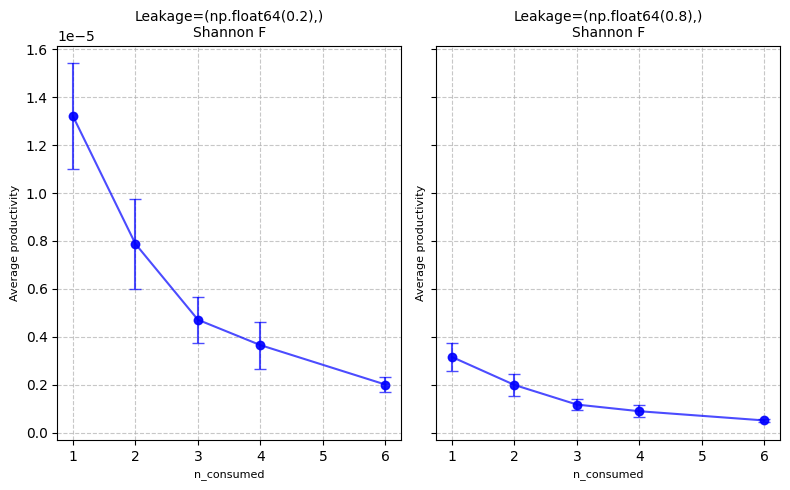

In [9]:
# Exclude rows where n_consumed equals 20
df_check_filtered = sampled_data.copy()

unique_n_consumed = df_check_filtered['n_consumed'].unique()

# Sort the 'n_consumed' values so colors are assigned in increasing order
unique_n_consumed = np.sort(unique_n_consumed)

# Generate parameter combinations
leakage_values = df_check_filtered['l'].unique()
combinations = list(itertools.product(leakage_values))

# Set up the figure with half the columns (no O panels)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes for easier iteration

# Define a discrete version of the 'viridis' colormap with enough distinct colors
n_colors = len(unique_n_consumed)
cmap = plt.cm.viridis  # Use 'viridis' colormap
colors = [cmap(i / n_colors) for i in range(n_colors)]  # Discretize the colormap

# Loop through each parameter combination and create plots (only for Shannon F)
for idx, (leakage) in enumerate(combinations):
    # Filter data for the current combination from df_check_filtered (Shannon F only)
    combo_data = df_check_filtered[
        (df_check_filtered['l'] == leakage)
    ]
    
    # Prepare axis for Shannon F
    ax_F = axes[idx]  # One panel for Shannon F
    
    # Loop through each unique 'n_consumed' and plot data for Shannon F
    avg_shannon_F = []
    std_shannon_F = []
    for n_cons in unique_n_consumed:
        current_data = combo_data[combo_data['n_consumed'] == n_cons]
        grouped_data = current_data.groupby('n_produced').agg(
            shannon_sp_avg=('productivity', 'mean'),
            shannon_sp_std=('productivity', 'std')
        ).reset_index()

        # Average over all n_produced values
        avg_shannon_F.append(grouped_data['shannon_sp_avg'].mean())
        std_shannon_F.append(grouped_data['shannon_sp_std'].mean())
    
    # Plot Shannon F
    ax_F.errorbar(
        unique_n_consumed, 
        avg_shannon_F, 
        yerr=std_shannon_F, 
        fmt='-o', color='b', alpha=0.7, capsize=4
    )
    ax_F.scatter(
        unique_n_consumed, 
        avg_shannon_F, 
        s=50, color='b', alpha=0.7, edgecolor='w', linewidth=0.5
    )
    
    # Set title for the current parameter combination
    ax_F.set_title(f'Leakage={leakage}\nShannon F', fontsize=10)
    
    # Set axis labels
    ax_F.set_xlabel('n_consumed', fontsize=8)
    ax_F.set_ylabel('Average productivity', fontsize=8)
    
    # Add grid lines
    ax_F.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()

Pearson correlation coefficient: -0.9212295172623497
Pearson P-value: 0.02622285840021443
Spearman correlation coefficient: -0.9999999999999999
Spearman P-value: 1.4042654220543672e-24


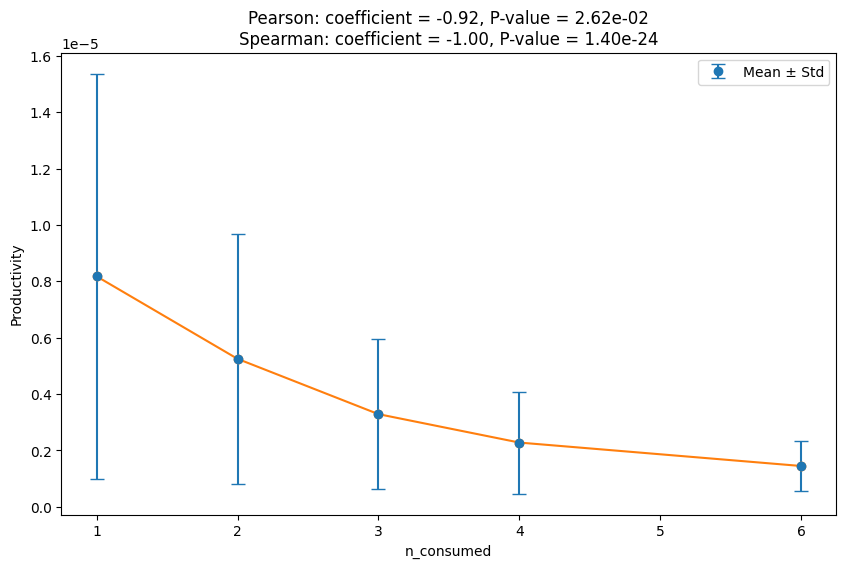

In [38]:
from scipy.stats import pearsonr, spearmanr

# Assuming df_filtered is your DataFrame

# Group by 'n_consumed' and calculate the mean and standard deviation of 'IH'
grouped = sampled_data.groupby('n_consumed')['productivity']
averaged_points = grouped.mean().reset_index()
averaged_points['std'] = grouped.std().values

# Calculate the Pearson correlation coefficient and p-value
pearson_corr, pearson_p_value = pearsonr(averaged_points['n_consumed'], averaged_points['productivity'])

# Calculate the Spearman correlation coefficient and p-value
spearman_corr, spearman_p_value = spearmanr(averaged_points['n_consumed'], averaged_points['productivity'])

print(f'Pearson correlation coefficient: {pearson_corr}')
print(f'Pearson P-value: {pearson_p_value}')
print(f'Spearman correlation coefficient: {spearman_corr}')
print(f'Spearman P-value: {spearman_p_value}')

# Plotting the averaged points with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(averaged_points['n_consumed'], averaged_points['productivity'], yerr=averaged_points['std'], fmt='o', capsize=5, label='Mean ± Std')
plt.plot(averaged_points['n_consumed'], averaged_points['productivity'], linestyle='-', marker='o')

# Add titles and labels
plt.title(
          f'Pearson: coefficient = {pearson_corr:.2f}, P-value = {pearson_p_value:.2e}\n'
          f'Spearman: coefficient = {spearman_corr:.2f}, P-value = {spearman_p_value:.2e}')
plt.xlabel('n_consumed')
plt.ylabel('Productivity')

# Add legend
plt.legend()

# Show the plot
plt.show()

/tmp/ipykernel_3109705/921338301.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = df_complete.groupby(['n_consumed', 'n_produced'], group_keys=False)\


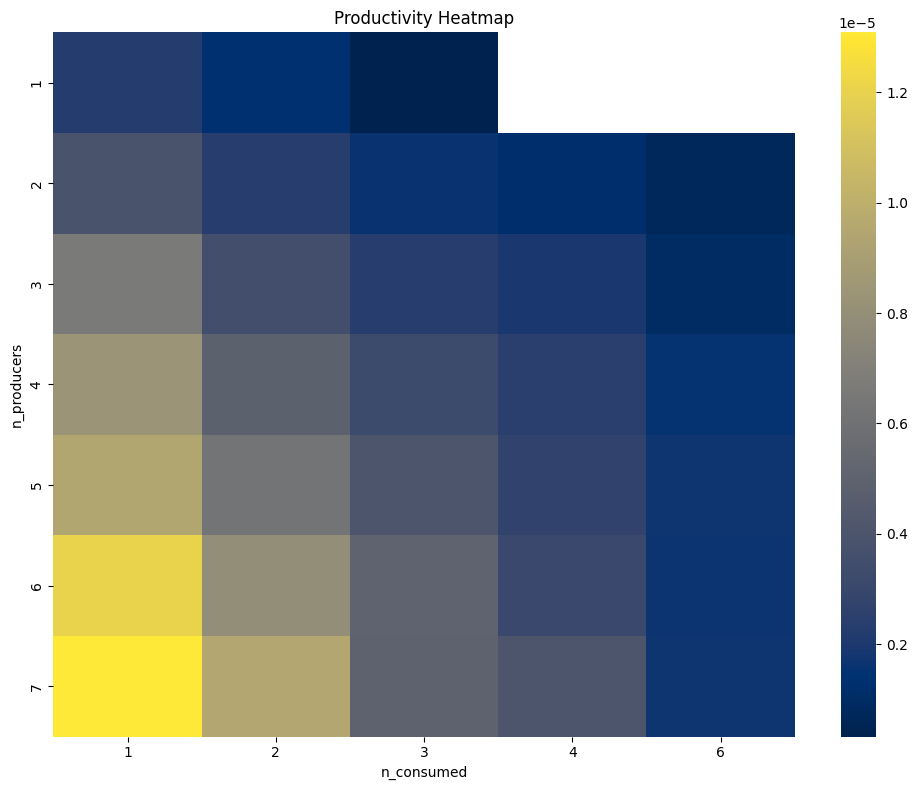

In [17]:
# Copy the DataFrame
df_complete = sampled_data.copy()

# Define the target size per group
target_size = 300  
unique_combinations = df_complete.groupby(['n_consumed', 'n_produced']).size()

# Calculate sample size per group
sample_per_group = target_size // len(unique_combinations)

# Sample data for all leakage groups together
sampled_data = df_complete.groupby(['n_consumed', 'n_produced'], group_keys=False)\
    .apply(lambda x: x.sample(min(len(x), sample_per_group), random_state=42))

# Compute mean productivity for each (n_consumed, n_produced)
diversity_combined = sampled_data.groupby(['n_consumed', 'n_produced'])['productivity'].mean().unstack(fill_value=np.nan)

# Find vmin and vmax for consistent color scaling
vmin, vmax = diversity_combined.min().min(), diversity_combined.max().max()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(diversity_combined.T, annot=False, fmt=".2f", cmap='cividis', cbar=True, vmin=vmin, vmax=vmax)

# Titles and labels
plt.title('Productivity Heatmap')
plt.xlabel('n_consumed')
plt.ylabel('n_producers')

# Show plot
plt.tight_layout()
plt.show()